## Libraries

In [1]:
import networkx as nx
import os
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import ast
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.tokenize import TweetTokenizer
import re
import random
import pickle
import gensim
from collections import Counter
import itertools
from networkx.algorithms.centrality import out_degree_centrality, betweenness_centrality, degree_centrality

# allowing the plot in line for seaborn
%matplotlib inline
plt.style.use('seaborn')

# enabling outlines line in histogram 
plt.rcParams["patch.force_edgecolor"] = True

## Function

In [23]:
def save_img(title, name):    
    plt.savefig(f'/Users/villons/Desktop/echo-chamers/src/analysis_images/{name}/{title}.png', 
                dpi = 300, quality = 95, format = 'png', pad_inches = 1000)
    
def community_pie_chart(graph, comm_type, name, study):
    
    communities = dict()
    for node in graph.nodes(data=True):
        if not(f'Comunità: {node[1][comm_type]}' in communities):
            communities[f'Comunità: {node[1][comm_type]}'] = 1
        else:
            communities[f'Comunità: {node[1][comm_type]}'] += 1
            
            
    com = list(communities.keys())
    com_comp = list(communities.values())
    colors = ['#b50000', '#0045b5']
    if com[0] != 'Comunità: 1':
        com[0], com[1] = com[1], com[0]
        com_comp[0], com_comp[1] = com_comp[1], com_comp[0]

    print(communities)
    
    fig, ax = plt.subplots()
    ax.pie(com_comp, labels = com, explode = [0, 0.1], shadow=True,
        startangle = 90, colors = colors, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')
    ax.set_title(f'Suddivisione community per {name}')
    save_img(f'Suddivisione community per {name}', study)
    plt.show() 
        
def create_graph_df(graph):
    # graph_df = pd.DataFrame(columns=['username', 'sentiment', 'weightComm', 'sentimentComm', 'topicComm', 'hybridComm', 'tweetTopic'])
    graph_df = pd.DataFrame(columns=['username', 'sentiment', 'weightComm', 'sentimentComm'])
    for node in tqdm(graph.nodes(data=True)):
        #new_row = [node[0], node[1]['sentiment'], node[1]['weightComm'], node[1]['sentimentComm'],
        #           node[1]['topicComm'], node[1]['hybridComm'], node[1]['tweetTopic']]
        new_row = [node[0], node[1]['sentiment'], node[1]['weightComm'], node[1]['sentimentComm']]
        graph_df.loc[len(graph_df)] = new_row
    return graph_df

def add_to_dictionary(dictionary, key):
    if key in dictionary:
        dictionary[key] += 1
    else:
        dictionary[key] = 1
    return dictionary

def plot_degree_distribution(graph, name, opt):
    degree_distribution = pd.DataFrame(columns=['degree_value', 'community', 'towards', 'placeholder'])
    colors = ['#b50000', '#0045b5']
        
    for node in tqdm(graph.nodes(data=True)):
        if opt == 0:
            title = f'Distribuzione per {name}'
                
            out_edges = list(graph.out_edges(node[0], data=True))
            in_edges = list(graph.in_edges(node[0], data=True))
            out_degree_values = 0
            in_degree_values = 0
            
            comm = node[1]['sentimentComm']
            
            for edge in out_edges:
                out_degree_values += edge[2]['weight']

            for edge in in_edges:
                in_degree_values += edge[2]['weight']

            degree_distribution.loc[len(degree_distribution)] = [out_degree_values, comm, 'outdegree', '']
            degree_distribution.loc[len(degree_distribution)] = [in_degree_values, comm, 'indegree', '']
        else:
            graph_name = graph.name.split('graph')[1]
            title = f'Distribuzione per {graph_name}'
            edges = list(graph.edges(node[0], data=True))
            edge_degree = 0
            comm = node[1]['weightComm']
            for edge in edges:
                edge_degree += edge[2]['weight']
            degree_distribution.loc[len(degree_distribution)] = [edge_degree, comm, 'total_degree', '']
            
    degree_value = degree_distribution['degree_value']
    removed_outliers = degree_value.between(degree_value.quantile(.25), degree_value.quantile(0.85))
    index_names = degree_distribution[~removed_outliers].index
    degree_distribution.drop(index_names, inplace=True)
    degree_distribution['degree_value'] = degree_distribution['degree_value'].apply(lambda x: float(x))
    

    fig, ax = plt.subplots()
    if opt == 1:
        x_value = 'placeholder'
    else:
        x_value = 'towards'
    
    ax = sns.violinplot(x=x_value, y='degree_value', hue='community', data=degree_distribution, split=True, palette=['blue', 'red'], scale='count', bw=0.2)
    ax.set_title(title)
    ax.set_xlabel('Distribuzione di grado')
    ax.set_ylabel('Numero di tweets')
    ax.legend(title='Community')
    save_img(title, name)
    plt.show()
    
def plot_sentiment_distribution(compact_graph, name, sentiment_df):
    
    fig, ax = plt.subplots()
    ax = sns.distplot(sentiment_df['sentiment'], hist=False, label='Sentimento su intero grafo')
    title = f'Distribuzione sentiment su grafo {name}'
    ax.set_title(title)
    ax.set_xlabel('Score sentimento')
    ax.set_ylabel('Distribuzione probabilità')
    ax.legend()
    save_img(title, name)
    plt.show()
    
    # columns = sentiment_df.columns[2:len(sentiment_df.columns)-1]
    columns = sentiment_df.columns[2:len(sentiment_df.columns)]
    print(columns)
    
    titles = ['strutturale', 'sentiment', 'topic', 'hybrid']
    index = 0
    for column in columns:
        title = f'Distribuzione sentimento nelle communities dato approccio {titles[index]}'
        sentiment_df_weight_0 = sentiment_df.query(f'{column} == 0')
        sentiment_df_weight_1 = sentiment_df.query(f'{column} == 1')
        fig, ax = plt.subplots()
        ax = sns.distplot(sentiment_df_weight_0['sentiment'], color='b', hist=False, label='Sentimento nella community 0')
        ax = sns.distplot(sentiment_df_weight_1['sentiment'], color='r', hist=False, label='Sentimento nella community 1')
        ax.set_title(title)
        ax.set_xlabel('Score sentimento')
        ax.set_ylabel('Distribuzione probabilità')
        ax.legend()
        save_img(title, name)
        plt.show()
        index += 1
        
def delete_outliers(dataset, field):
    
    dataset_value = dataset[field]
    removed_outliers = dataset_value.between(dataset_value.quantile(.25), dataset_value.quantile(0.85))
    index_names = dataset[~removed_outliers].index
    dataset = dataset.drop(index_names)
    return dataset
    
def plot_snsdist(metadata, field):
    metadata_no_out = delete_outliers(metadata, field)
    fig, ax = plt.subplots()
    com_0 = metadata_no_out.query('community == "0"')
    com_1 = metadata_no_out.query('community == "1"')
    
    ax = sns.distplot(com_0[field], hist=False, label=f'{field} community 0')
    ax = sns.distplot(com_1[field], hist=False, label=f'{field} community 1')
    
    title = f'Valutazione {field}'
    ax.set_title(title)
    ax.set_xlabel(f'{field}')
    ax.set_ylabel(f'Distribuzione di probabiltà')
    ax.legend()
    save_img(title, 'COVID-19')
    plt.show()
    
def get_metadata():
    files = os.listdir()
    
    if 'complete_metadata.csv' not in files:
        medatada_df = pd.DataFrame(columns=['username', 'created', 'defaultProfile',
                                            'DefaultImage', 'description', 'numLikes', 
                                            'numFollowers', 'numFollowing', 'numGroups', 
                                            'location', 'numStatuses', 'verified', 'community',
                                            'sentiment', 'placeholder'])
        for node in tqdm(covid_complete.nodes(data=True)):
            row = [node[0]]
            
            if 'description' in covid_metadata.nodes[node[0]]:
                for medatada in covid_metadata.nodes[node[0]]:
                    if medatada != 'sentimentComm':
                        row += [covid_metadata.nodes[node[0]][medatada]]
            else:
                row += [np.nan]*(len(medatada_df.columns)-4)

            row += [node[1]['sentimentComm']]
            row += [node[1]['sentiment']]
            row += ['']
            medatada_df.loc[len(medatada_df)] = row
        medatada_df.to_csv('./complete_metadata.csv', index=False, encoding='utf-8')
    else:
        medatada_df = pd.read_csv('./complete_metadata.csv')
    
    for field in ['numFollowers', 'numLikes', 'numFollowing', 'numGroups', 'numStatuses']:
        medatada_df[field] = medatada_df[field].apply(lambda x: float(x))
    
    medatada_df['placeholder'] = [' ']*len(medatada_df)
    medatada_df.dropna(axis='index', how='any', inplace=True)
    
    medatada_df['created'] = pd.to_datetime(medatada_df['created'], format='%Y-%m-%d')
    
    return medatada_df


def verified_pie_chart(community, metadata_df):
    comm = metadata.query(f'community == {community}')
    verified_dict = dict(comm.verified.value_counts())
    del verified_dict['-1']
    verified_dict = dict(sorted(verified_dict.items()))
    title = f'Account verificati per la community {community}'
    
    verified = list(verified_dict.keys())
    count_ver = list(verified_dict.values())
    # colors = ['#0045b5', '#b50000']
    
    print(verified)
    
    fig, ax = plt.subplots()
    ax.pie(count_ver, labels = verified, explode = [0, 0.1], shadow=True,
        startangle = 90, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')
    ax.set_title(title)
    save_img(title, 'COVID-19')
    plt.show() 
    
def default_pie_chart(community, metadata_df, element, opt = 0):
    comm = metadata.query(f'community == {community}')
    if element == 'defaultProfile':
        default_dict = dict(comm.defaultProfile.value_counts())
        title = f'Profilo di default per utenti community {community}'
    elif element == 'DefaultImage':
        default_dict = dict(comm.DefaultImage.value_counts())
        title = f'Immagine di default per utenti community {community}'
        
    if opt == 1:
        title = f'{title} dati account 2020'
    
    if '-1' in default_dict:
        del default_dict['-1']
    default_dict = dict(sorted(default_dict.items()))
    
    verified = list(default_dict.keys())
    count_ver = list(default_dict.values())
    # colors = ['#0045b5', '#b50000']
    
    fig, ax = plt.subplots()
    ax.pie(count_ver, labels = verified, explode = [0, 0.1], shadow=True,
        startangle = 90, wedgeprops={'edgecolor': 'black'}, autopct='%1.1f%%')
    ax.set_title(title)
    save_img(title, 'COVID-19')
    plt.show() 
    
def topic_distribution(graph_df, name):
    
    titles = ['strutturale', 'sentiment', 'topic', 'hybrid']
    cont = 0
    
    comm_types = list(graph_df.columns)[2:6]
    
    for comm_type in comm_types:
        topic_cont = dict()
        topic_cont_0 = dict()
        topic_cont_1 = dict()
        for _, row in graph_df.iterrows():
            topics = ast.literal_eval(row['tweetTopic'])
            community = row[f'{comm_type}']
            for topic in topics:
                if topic == 0:
                    topic_cont = add_to_dictionary(topic_cont, topic)
                    if community == 0:
                        topic_cont_0 = add_to_dictionary(topic_cont_0, topic)
                    else:
                        topic_cont_1 = add_to_dictionary(topic_cont_1, topic)
                    
                
        topic_cont = dict(sorted(topic_cont.items()))
        topic_cont_0 = dict(sorted(topic_cont_0.items()))
        topic_cont_1 = dict(sorted(topic_cont_1.items()))


        title = f'Distribuzione topic con approccio {titles[cont]}'

        width = 0.25
        fig, ax = plt.subplots()
        fig.set_size_inches(18.5, 10.5)
        x_indexes = np.arange(1, len(topic_cont)+1)
        ax.bar(x_indexes - width, topic_cont.values(), width = width, color = '#444444', label = 'Su tutto il grafo')
        ax.bar(x_indexes, topic_cont_0.values(), width = width, color = '#020ee8', label = 'Community 0')
        ax.bar(x_indexes + width, topic_cont_1.values(), width = width, color = '#e00707', label = 'Community 1')
        plt.xticks(ticks=x_indexes, labels=x_indexes)
        ax.legend()
        ax.set_xlabel('ID topic')
        ax.set_ylabel('tweets associati ai topic')
        ax.set_title(title)
        
        cont += 1

        save_img(title, name)
        plt.show()
        
def plot_hist_2020(meta_2020):
    com_0 = meta_2020.query('community == 0')
    com_1 = meta_2020.query('community == 1')
    
    colors = ['#0045b5', '#b50000']
    
    title = 'Numerosità account creati nel 2020 in funzione delle community'
    fig, ax = plt.subplots()
    x_indexes = np.arange(0, 2)
    ax.bar(x_indexes, [len(com_0), len(com_1)], width = 0.5, color=colors)
    plt.xticks(ticks=x_indexes, labels=x_indexes)
    ax.legend()
    ax.set_xlabel('Community')
    ax.set_ylabel('# Account creati nel 2020')
    ax.set_title(title)
    save_img(title, 'COVID-19')
    plt.show()
    
def plot_join_plot(field1, fiel2, metadata, title):

    fig, ax = plt.subplots()
    ax.set_xlabel(field1)
    ax.set_ylabel(fiel2)
    ax.set_title(title)
    ax = sns.jointplot(x=field1, y=fiel2, data=metadata, color='green', kind='reg')
    #save_img(title, 'COVID-19')
    plt.show()

def delete_outliers(df, field):
    values = df[field]
    removed_outliers = values.between(values.quantile(.25), values.quantile(0.75))
    index_names = df[~removed_outliers].index
    df.drop(index_names, inplace=True)
    return df
    
def join_plot(field1, field2, metadata, title):
    
    metadata_df = delete_outliers(field1, metadata)
    metadata_df = delete_outliers(field2, metadata)
    
    comm_0 = metadata_df.query('community == "0"')
    comm_1 = metadata_df.query('community == "1"')

    plot_join_plot(field1, field2, comm_0, title)
    plot_join_plot(field1, field2, comm_1, title)
    
def delete_url(tweet):
    for i in range(len(tweet)):
        tweet[i] = re.sub(r'\b(http:|www\.)(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r"http\S+", '', tweet[i])
        tweet[i] = re.sub(r'http:\\*/\\*/.*?\s', '', tweet[i])
        tweet[i] = re.sub(r'https:\\*/\\*/.*?\s', '', tweet[i])
        tweet[i] = re.sub(r"twitter.(\w+)", ' ', tweet[i], flags=re.MULTILINE)
        tweet[i] = re.sub(r'://(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r"://", ' ', tweet[i], flags=re.MULTILINE)
        tweet[i] = re.sub(r"/(\w+)", ' ', tweet[i], flags=re.MULTILINE)
        tweet[i] = re.sub(r"#", '', tweet[i])
        tweet[i] = re.sub(r'陈秋实(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'full(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'utm_source(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'utm_medium=(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'=social(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'=web&(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'utm_campaign(?:[^\s,.!?]|[,.!?](?!\s))+', '', tweet[i])
        tweet[i] = re.sub(r'.html', '', tweet[i])
        tweet[i] = re.sub(r'·ðŸ', '', tweet[i])
        tweet[i] = re.sub(r'°ðŸ', '', tweet[i])
        
        if '°ðŸ' in tweet[i]:
            tweet[i].replace('°ðŸ', '')
    return tweet

def word_cloud(words, mask_id):
    
    if mask_id == -1 or mask_id == 0:
        papers_mask = np.array(Image.open("./twitter_mask_0.png"))
    else:
        papers_mask = np.array(Image.open("./twitter_mask_1.png"))
    stopwords = set(STOPWORDS)
    stopwords.update(['NoDescription', 'https co', 'ðŸ', 'ãƒ'])
    wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white", 
                          mode="RGBA", max_words=1000, mask = papers_mask).generate(words)

    image_colors = ImageColorGenerator(papers_mask)
    
    return wordcloud, image_colors

def preprocessing_summary(summary):
    #with open("../../preprocessing/stopwords.txt", "rb") as fp:
    #    stop_words = pickle.load(fp)
    #stop_words.append('NoDescription')
    #stop_words.append('We')
    #stop_words.append('new')
    
    stop_words = {'NoDescription', 'We', 'new', 'New', 'love', 'Love', 
                  'No', 'the', 'The', 'news', 'News', 'WWG', '1WGA', 'ðŸ', 
                  'ãƒ', '°ðŸ', 'Retired', 'Journalist', 'world', 'Former', 'Writer',
                 'Twitter', 'people', 'politic', '°ðŸ ', ' °ðŸ ', ' °ðŸ', 'I\'m', '°ðŸ',
                 'politics', 'life', 'ºðŸ', ' ºðŸ', 'ºðŸ ', ' ºðŸ ', 'Editor', 'time',
                 'Tweet', 'alum', 'Tweet', 'live', 'Global', 'music', 'If', 'now',
                 'not endorsement', 'Follow', 'us', 'now', 'one'}
    summary = delete_url(summary)
    tokening = TweetTokenizer(strip_handles=True, reduce_len=True)
    summary_series = pd.Series(summary)
    summary_tokenized = summary_series.apply(tokening.tokenize)
    for sentence in range(len(summary_tokenized)):
        #for token in summary_tokenized[sentence]:
        #    if 'new' in token:
        #        print(f'prima{token}dopo')
        #        print(summary_tokenized[sentence])
        #        print()
                
        not_number = [token for token in summary_tokenized[sentence] if not token.isdigit()]
        summary_tokenized[sentence] = not_number
    summary_tokenized_stop = summary_tokenized.apply(lambda x: [item for item in x if item not in stop_words])
    list_done = list(summary_tokenized_stop)
    list_done = [item for sublist in list_done for item in sublist]
    return list_done

def summary_word_cloud(meta_df, title, opt):
    summary = list()
    cont = 0
    
    for _, row in meta_df.iterrows():
        row['description'] = row['description'].replace('°ðŸ', '').replace('ºðŸ', '')
        if opt == 1:
            pass
            #row['description'] = row['description'].replace('MAGA', '').replace('Trump', '').replace('Anchor', '').replace('KAG', '').replace('TRUMP', '')
        summary.append(row['description'])
    summ_clean = preprocessing_summary(summary)
    
    print()
            
    wordcloud, colors = word_cloud(' '.join(summ_clean), opt - 1)
    fig, ax = plt.subplots(figsize=[20,20])
        
    plt.title(title)
    ax.axis("off")
    if opt == 0:
        ax.imshow(wordcloud.recolor(color_func=grey_color_func), interpolation="bilinear")
    elif opt == 1:
        ax.imshow(wordcloud.recolor(color_func=blue_color_func), interpolation="bilinear")
    elif opt == 2:
        ax.imshow(wordcloud.recolor(color_func=red_color_func), interpolation="bilinear")
    save_img(title, 'COVID-19')
    plt.show()
    

# 213, 82, 42 --> blue
# 213, 63, 5 --> black
# 0, 98, 44 --> red

# for total
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(213, 63%, 5%)"

# for community 0
def red_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 98%, 44%)"

# for community 1
def blue_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(213, 82%, 42%)"


def extract_community(G, id_com, type_com):
    community_node = list()
    
    for node in G.nodes():
        if  G.nodes[node][type_com] == id_com:
            community_node.append(node)
    subgraph = G.subgraph(community_node)
    return subgraph


def compute_degree_and_betweenness(graph, opt):
    graph_multi = create_direct_multigraph(graph)
    print(nx.info(graph_multi))
    
    if opt == 0:
        degree = degree_centrality(graph_multi)
    elif opt == 1:
        degree = out_degree_centrality(graph_multi)
    
    degree_sorted = sorted(degree.items(), key=lambda x: x[1], reverse=True)
    print(degree_sorted[0:10])
    
    print()
    
    k = int(len(graph)*0.6)
    betweenness = betweenness_centrality(graph, k = k, normalized = True, weight = 'weight')
    betweenness_sorted = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)
    print(betweenness_sorted[0:10])
    print()

## Garimella


In [ ]:
os.chdir('/Users/villons/Desktop/echo-chamers/src/data/garimella_data')

In [ ]:
beefban = nx.read_gml('./Graph/beefban.gml')
ukraine = nx.read_gml('./Graph/ukraine.gml')
kissing_day = nx.read_gml('./Graph/nationalkissingday.gml')

In [ ]:
def create_direct_multigraph(graph):
    G_multi = nx.MultiDiGraph()
    for edge in graph.edges(data = True):
        weight = edge[2]['weight']
        for _ in range(int(weight)):
            G_multi.add_edge(edge[0], edge[1])
    
    print(nx.info(G_multi))
    return G_multi

#### Centrality analysis

In [ ]:
comm_0 = extract_community(kissing_day, 0, 'weightComm')
comm_1 = extract_community(kissing_day, 1, 'weightComm')

In [ ]:
compute_degree_and_betweenness(comm_0, 0)
compute_degree_and_betweenness(comm_1, 0)

#### Pie chart community membership

In [ ]:
community_pie_chart(beefban, 'weightComm', 'BeefBan con approccio strutturale', 'Garimella')
community_pie_chart(ukraine, 'weightComm', 'Ukraine con approccio strutturale', 'Garimella')
community_pie_chart(kissing_day, 'weightComm', 'Kissingday con approccio strutturale', 'Garimella')

#### Degree distribution

In [ ]:
plot_degree_distribution(beefban, 'Garimella', 1)

In [ ]:
plot_degree_distribution(ukraine, 'Garimella', 1)

In [ ]:
plot_degree_distribution(kissing_day, 'Garimella', 1)

## Covid-19

In [3]:
os.chdir('/Users/villons/Desktop/echo-chamers/src/data/corona_virus')

In [4]:
covid_compact = nx.read_gml('./Graph/Final_Graph_Covid.gml')
covid_complete = nx.read_gml('./Graph/Final_DiGraph_Covid.gml')
covid_metadata = nx.read_gml('./Graph/Final_DiGraph_Covid_data.gml')

In [5]:
for node in covid_compact.nodes(data=True):
    covid_metadata.nodes[node[0]]['sentimentComm'] = node[1]['sentimentComm']

In [6]:
covid_19_df = create_graph_df(covid_compact)

#### Centrality analysis

In [ ]:
comm_0 = extract_community(covid_metadata, 0, 'sentimentComm')
comm_1 = extract_community(covid_metadata, 1, 'sentimentComm')
compute_degree_and_betweenness(comm_0, 1)
compute_degree_and_betweenness(comm_1, 1)

#### Pie chart community membership

In [ ]:
community_pie_chart(covid_compact, 'weightComm', 'COVID-19 con approccio strutturale', 'COVID-19')
community_pie_chart(covid_compact, 'sentimentComm', 'COVID-19 con approccio sentiment e strutturale', 'COVID-19')
community_pie_chart(covid_compact, 'topicComm', 'COVID-19 con approccio topic e strutturale', 'COVID-19')
community_pie_chart(covid_compact, 'hybridComm', 'COVID-19 con approccio ibrido', 'COVID-19')

#### Distribution plot different approach

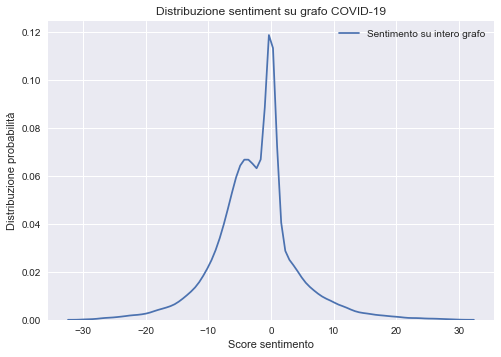

Index(['weightComm', 'sentimentComm'], dtype='object')


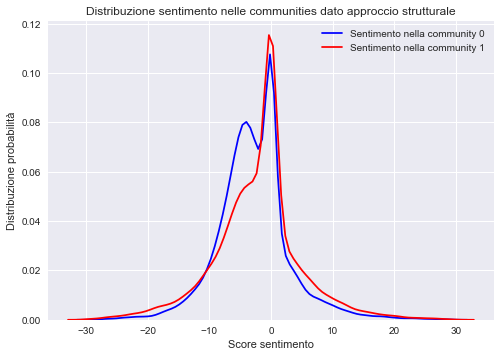

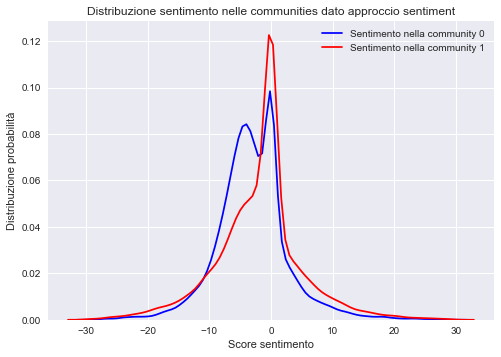

In [7]:
plot_sentiment_distribution(covid_metadata, 'COVID-19', covid_19_df)

#### Topic talking

In [ ]:
topic_distribution(covid_19_df, 'COVID-19')

#### Degree distribution

In [ ]:
plot_degree_distribution(covid_metadata, 'COVID-19', 0)

#### Metadata analysis

In [18]:
metadata = get_metadata()

In [ ]:
plot_snsdist(metadata, 'numFollowers')

In [ ]:
plot_snsdist(metadata, 'numLikes')

In [ ]:
plot_snsdist(metadata, 'numStatuses')

['False', 'True']


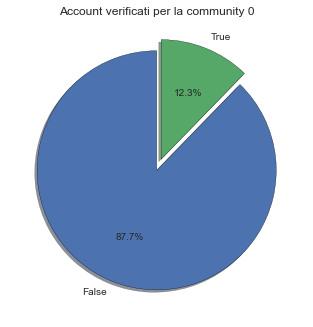

['False', 'True']


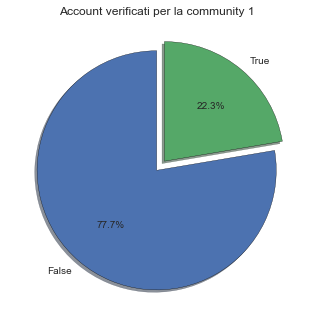

In [9]:
verified_pie_chart("0", metadata)
verified_pie_chart("1", metadata)

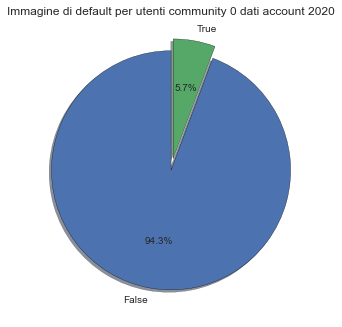

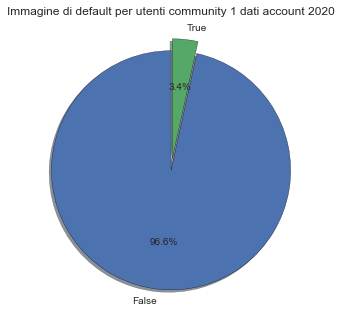

In [11]:
filt = (metadata['created'] >= '2020')
metadata_2020 = metadata.loc[filt]
default_pie_chart('0', metadata_2020, 'DefaultImage', 1)
default_pie_chart('1', metadata_2020, 'DefaultImage', 1)

No handles with labels found to put in legend.


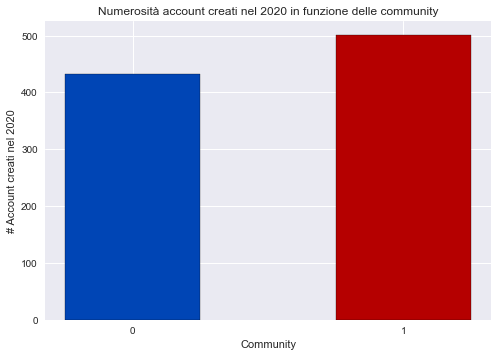

In [19]:
plot_hist_2020(metadata_2020)

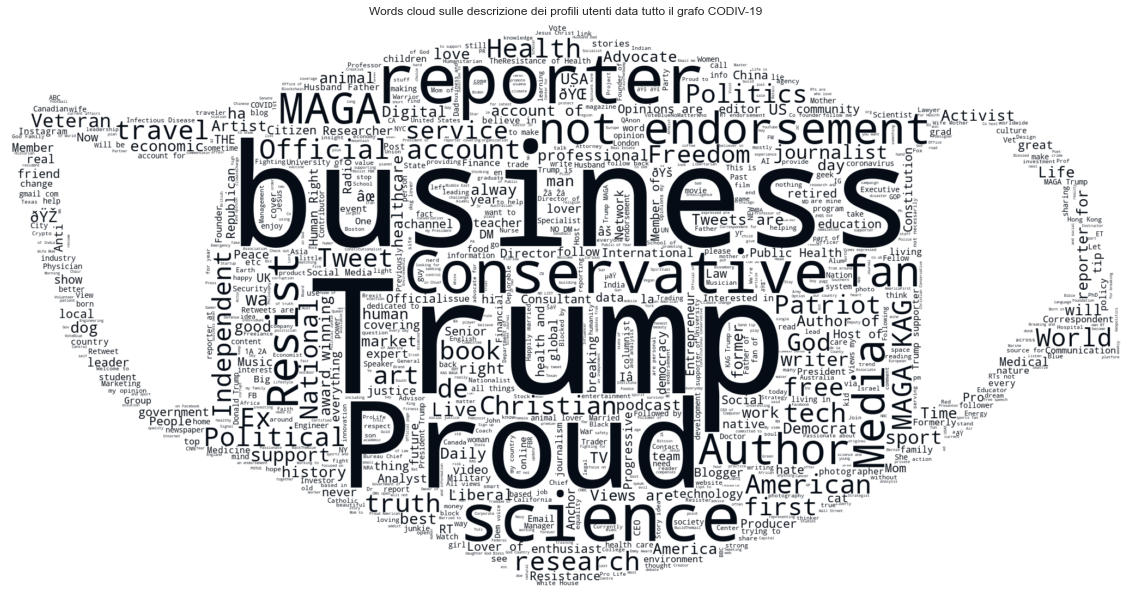

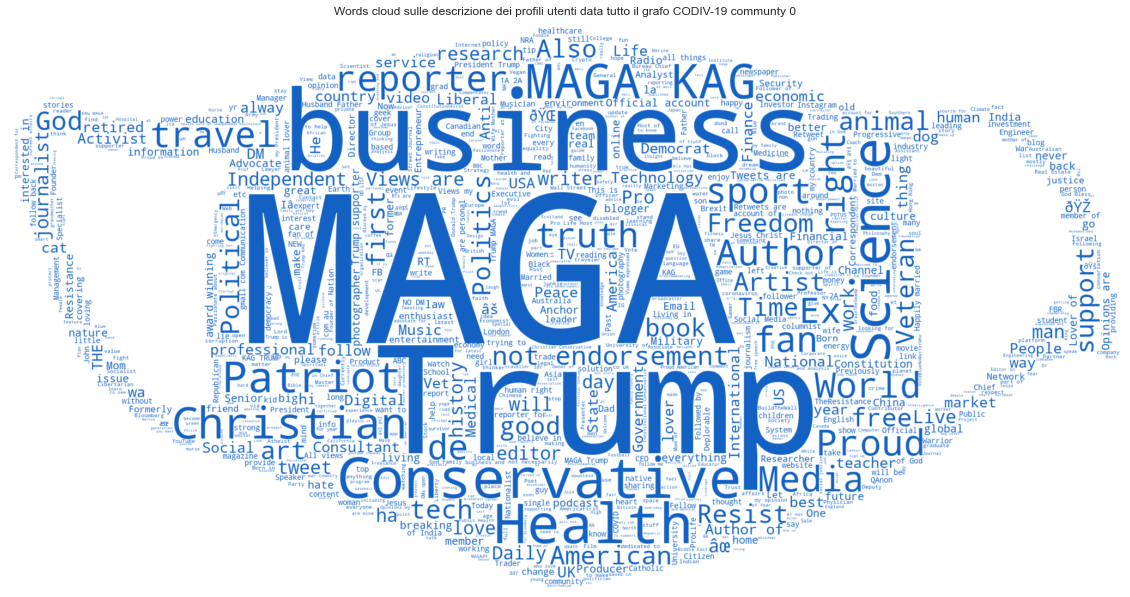

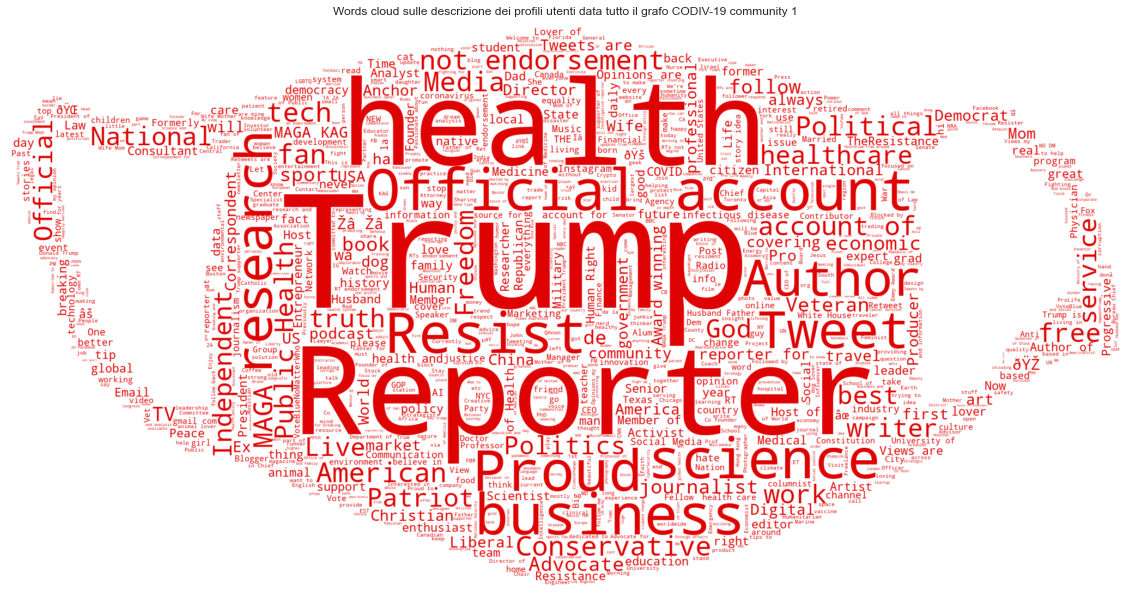

In [24]:
summary_word_cloud(metadata, 'Words cloud sulle descrizione dei profili utenti data tutto il grafo CODIV-19', 0)
comm_0 = metadata.query('community == 0')
summary_word_cloud(comm_0, 'Words cloud sulle descrizione dei profili utenti data tutto il grafo CODIV-19 communty 0', 1)
comm_1 = metadata.query('community == 1')
summary_word_cloud(comm_1, 'Words cloud sulle descrizione dei profili utenti data tutto il grafo CODIV-19 community 1', 2)

In [ ]:
tweet_word_cloud(covid_metadata, 'Wordcloud tweet intra community 0', 0, 'COVID-19')

In [ ]:
tweet_word_cloud(covid_metadata, 'Wordcloud tweet intra community 1', 1, 'COVID-19')

In [ ]:
tweet_word_cloud(covid_metadata, 'Wordcloud tweet extra community', 2, 'COVID-19')

## Vax

In [ ]:
os.chdir('/Users/villons/Desktop/echo-chamers/src/data/vax_no_vax')

In [ ]:
vax_compact = nx.read_gml('Graph/Final_Graph_vax.gml')
vax_complete = nx.read_gml('Graph/Final_DiGraph_Vax.gml')

In [ ]:
print(nx.info(vax_complete))

In [ ]:
vaccination_df = create_graph_df(vax_compact)

In [ ]:
print(nx.info(vax_complete))

#### Centrality

In [ ]:
comm_0 = extract_community(vax_complete, 0, 'sentimentComm')
comm_1 = extract_community(vax_complete, 1, 'sentimentComm')
compute_degree_and_betweenness(comm_0, 1)
compute_degree_and_betweenness(comm_1, 1)

#### Pie chart community membership

In [ ]:
community_pie_chart(vax_compact, 'weightComm', 'Vaccinazioni con approccio strutturale', 'Vaccination')
community_pie_chart(vax_compact, 'sentimentComm', 'Vaccinazioni con approccio sentiment e strutturale', 'Vaccination')
community_pie_chart(vax_compact, 'topicComm', 'Vaccinazioni con approccio topic e strutturale', 'Vaccination')
community_pie_chart(vax_compact, 'hybridComm', 'Vaccinazioni con approccio ibrido', 'Vaccination')

#### Distribution plot different approach

In [ ]:
plot_sentiment_distribution(vax_compact, 'Vaccination', vaccination_df)

#### Topic talking

In [ ]:
topic_distribution(vaccination_df, 'Vaccination')

#### Degree distribution

In [ ]:
plot_degree_distribution(vax_complete, 'Vaccination', 0)

In [ ]:
def preprocess(text):
    result = []
    for token in gensim.utils.simple_preprocess(text):
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(token)
    return result

def add_stop_words_covid(start_stop_words):
    start_stop_words.append('coronavirus')
    start_stop_words.append('covid coronavirus')
    start_stop_words.append('covid')
    start_stop_words.append('outbreak')
    start_stop_words.append('ncov')
    start_stop_words.append('ncov ncov')
    start_stop_words.append('coronavirus covid')
    start_stop_words.append('cases coronavirus')
    start_stop_words.append('coronavirus coronaviru')
    start_stop_words.append('coronavirus spread')
    start_stop_words.append('coronavirus case')
    start_stop_words.append('coronavirus outbreak')
    start_stop_words.append('coronaviru')
    start_stop_words.append('corona viru')
    start_stop_words.append('viru')
    start_stop_words.append('corona')
    start_stop_words.append('china coronavirus')
    start_stop_words.append('wuhan china')
    start_stop_words.append('china')
    start_stop_words.append('China')
    start_stop_words.append('confirmed case')
    start_stop_words.append('confirmed')
    start_stop_words.append('case')
    start_stop_words.append('novel coronavirus')
    start_stop_words.append('novel')
    start_stop_words.append('coronavirus')
    start_stop_words.append('Coronavirus')
    start_stop_words.append('cases')
    start_stop_words.append('COVID')
    start_stop_words.append('breaking')
    start_stop_words.append('CoronavirusOutbreak')
    start_stop_words.append('Wuhan')
    start_stop_words.append('BREAKING')
    start_stop_words.append('news')
    start_stop_words.append('virus')
    start_stop_words.append('says')
    start_stop_words.append('chinese')
    start_stop_words.append('deaths')
    start_stop_words.append('live')
    start_stop_words.append('infected')
    start_stop_words.append('reports')
    return start_stop_words

def add_stop_words_vaccination(start_stop_words):
    start_stop_words.append('vaccination')
    start_stop_words.append('vaccine')
    start_stop_words.append('vaccines')
    start_stop_words.append('diseases')
    start_stop_words.append('vaccine')
    start_stop_words.append('vaccines')
    start_stop_words.append('vaccinated')
    start_stop_words.append('measles')
    start_stop_words.append('forced')
    start_stop_words.append('like')
    start_stop_words.append('rates')
    start_stop_words.append('outbreaks')
    start_stop_words.append('getting')
    start_stop_words.append('know')
    start_stop_words.append('want')
    start_stop_words.append('school')
    start_stop_words.append('cases')
    start_stop_words.append('think')
    start_stop_words.append('year')
    start_stop_words.append('polio')
    start_stop_words.append('people')
    start_stop_words.append('rabies')
    start_stop_words.append('today')
    start_stop_words.append('years')
    start_stop_words.append('work')
    start_stop_words.append('infection')
    start_stop_words.append('ebola')



    
    return start_stop_words

def clean_data(tweets, name):
    with open("/Users/villons/Desktop/echo-chamers/src/preprocessing/stopwords.txt", "rb") as fp:
        stop_words = pickle.load(fp) 
    if name == 'COVID-19':
        stop_words = add_stop_words_covid(stop_words)
    elif name == 'Vaccination':
        stop_words = add_stop_words_vaccination(stop_words)
    
    tweets = delete_url(list(set(tweets)))
    tokening = TweetTokenizer(strip_handles=True, reduce_len=True)
    tweet_series = pd.Series(tweets)
    tweets_tokenized = tweet_series.apply(tokening.tokenize)
    tweets_tokenized_stop = tweets_tokenized.apply(lambda x: [item for item in x if item not in stop_words])
    list_done = list(tweets_tokenized_stop)
    clean_tweet = list()
    for tweet in tqdm(list_done, desc='tweet recomposed'):
        sentence = ''
        for word in tweet:
            sentence += f'{word} '
        clean_tweet.append(sentence)
    df = pd.DataFrame(np.array(clean_tweet).reshape(len(clean_tweet),1), columns = ['Tweet'])
    processed_docs = df['Tweet'].map(preprocess)
    processed_docs = processed_docs.apply(lambda x: [item for item in x if item not in stop_words])
    return processed_docs

def tweet_word_cloud(graph, title, comm_number, name, com_type = 'sentimentComm'):
    tweet_com = list()

    
    for edge in graph.edges(data=True):
        if comm_number != 2:
            if (graph.nodes[edge[0]][com_type] == graph.nodes[edge[1]][com_type]
                and graph.nodes[edge[0]][com_type] == comm_number):
                    tweet_com.append(edge[2]['tweets'])
                    if name == 'Vaccination':
                        tweet_com.append(edge[2]['hashtags'])
        else:
            if graph.nodes[edge[0]][com_type] != graph.nodes[edge[1]][com_type]:
                tweet_com.append(edge[2]['tweets'])
            
    
    tweet_com = [item for sublist in tweet_com for item in sublist]
    
    processed_docs = clean_data(tweet_com, name)
    
    # return processed_docs

    clean = [item for sublist in processed_docs for item in sublist]
    
    print(len(clean))
    if name == 'Vaccination':
        wordcloud, colors = word_cloud(' '.join(clean), 1)
    else:
        wordcloud, colors = word_cloud(' '.join(clean), comm_number)
    fig, ax = plt.subplots(figsize=[20,20])
        
    plt.title(title)
    ax.axis("off")
    if comm_number == 0:
        ax.imshow(wordcloud.recolor(color_func=blue_color_func), interpolation="bilinear")
    elif comm_number == 1:
        ax.imshow(wordcloud.recolor(color_func=red_color_func), interpolation="bilinear")
    elif comm_number == 2:
        ax.imshow(wordcloud.recolor(color_func=grey_color_func), interpolation="bilinear")
    save_img(title, name)
    plt.show()


def get_counter(df):
    sentences = (list(itertools.chain(df)))
    flat_list = [item for sublist in sentences for item in sublist]
    c = Counter(flat_list)
    return c

In [ ]:
tweet_word_cloud(vax_complete, 'Wordcloud tweet intra community 0', 0, 'Vaccination')

In [ ]:
tweet_word_cloud(vax_complete, 'Wordcloud tweet intra community 1', 1, 'Vaccination')

In [ ]:
tweet_word_cloud(vax_complete, 'Wordcloud tweet extra community', 2, 'Vaccination')